# Implicit Neural Representation with Periodic Activation Function

https://proceedings.neurips.cc/paper/2020/file/53c04118df112c13a8c34b38343b9c10-Paper.pdf


## Introduction

提出利用周期性激活函数进行隐形神经表欧式，并证明其有效性。

具有周期性激活函数的MLPs的方法比ReLU-MLPs还有定位编码策略都更好

[Ben Mildenhall, Pratul P Srinivasan, Matthew Tancik, Jonathan T Barron, Ravi Ramamoorthi, and Ren Ng.
Nerf: Representing scenes as neural radiance fields for view synthesis. In Proc. ECCV, 2020]

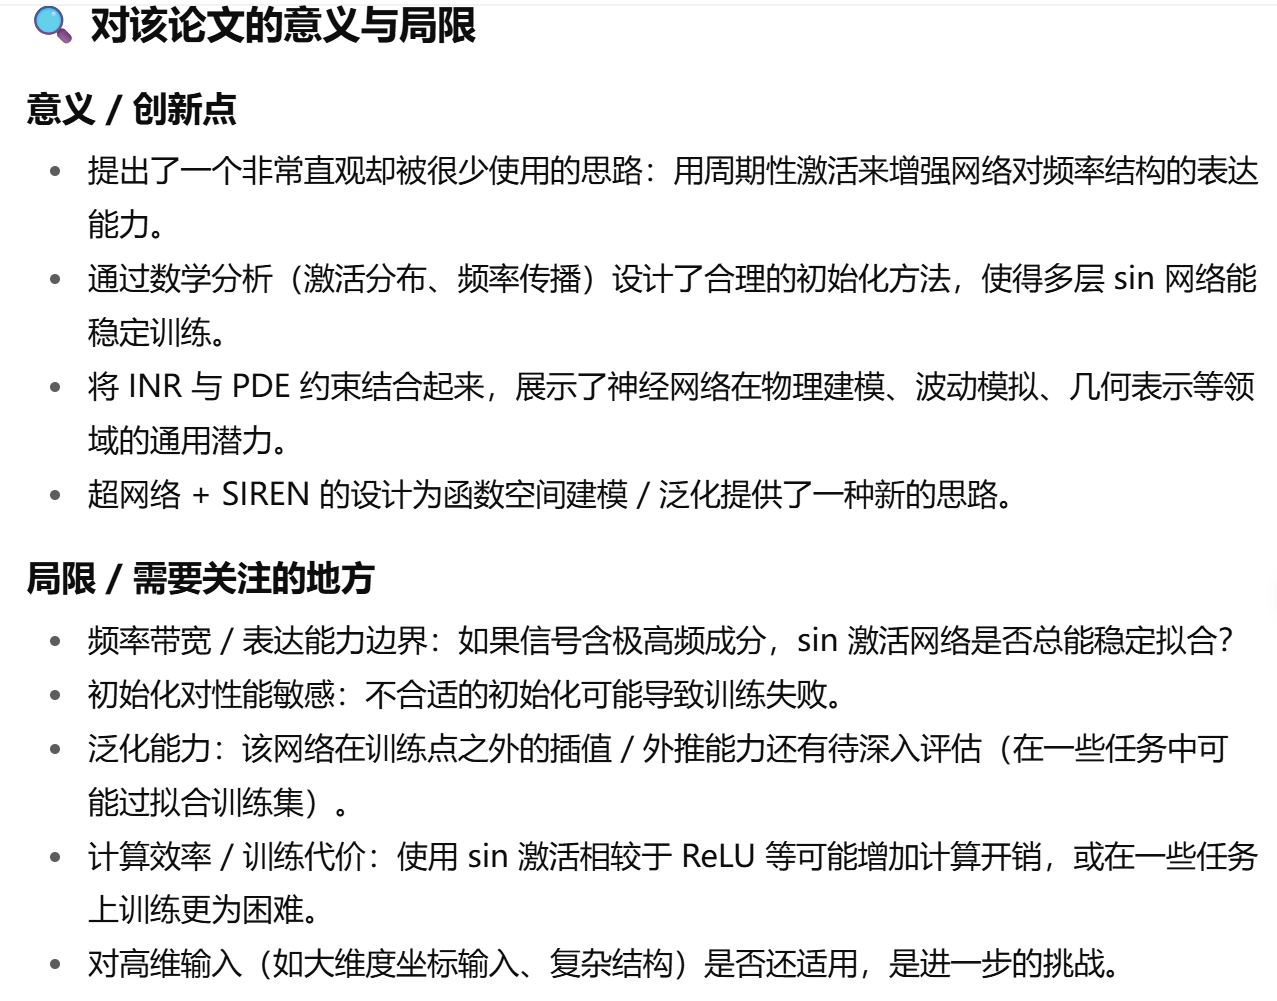

> sin激活的函数的导数本身也是sin激活的函数的一类，求导后保留了性质
> 激活后对分布会近似beta分布


## background

### What are the advantages of ontinuous parameterization?

- 它比离散表示更节省内存:存储成本与神经网络参数量有关，与空间分辨率无关，离散网格的存储随分辨率线性增长

- 神经网络本身可微，天然支持梯度（对物理模拟、优化有利），可微性意味着可以通过解析方法（例如自动微分）计算梯度和高阶导数，这再次使这些模型独立于传统网格分辨率。

- 更能模拟细节，这些细节的限制不是由王哥哥分辨率决定，而是由网络架构的容量决定。

- 连续隐式表示将空间信号的存储问题转化为学习函数的问题：

传统的存储图像是存储一个像素矩阵，而SIREN存储图像是学医一个映射函数。

> 具有良好导数的隐式神经表示可能为解决逆问题（如微分方程）提供一套新的工具箱。



### What's the problem for ReLU and other activation functions:(like tanh,softmax)?


| 激活函数              | 数学形式           | 特点             |
| ----------------- | -------------- | -------------- |
| ReLU              | ( \max(0, x) ) | 简单高效，但不能表示高频信号 |
| tanh / sigmoid    | 平滑、适合小范围输入     | 容易梯度消失         |
| **sin(x)**（SIREN） | 周期性、高频表达能力强    | 可表示连续复杂信号      |



- 基于ReLU的MLPs缺乏表示底层信号中细微细节的能力，并且通常不能表示目标信号的导数

> 1. 这是由于ReLU的网络是分段线性的，它们的二阶导数为零,因此无法模拟自然信号高阶导数中包含的信息.
> 2. 其他激活函数，如 tanh 或 softplus 能够表示高阶导数，但我们证明它们的导数通常行为不佳，并且也无法表示细微细节

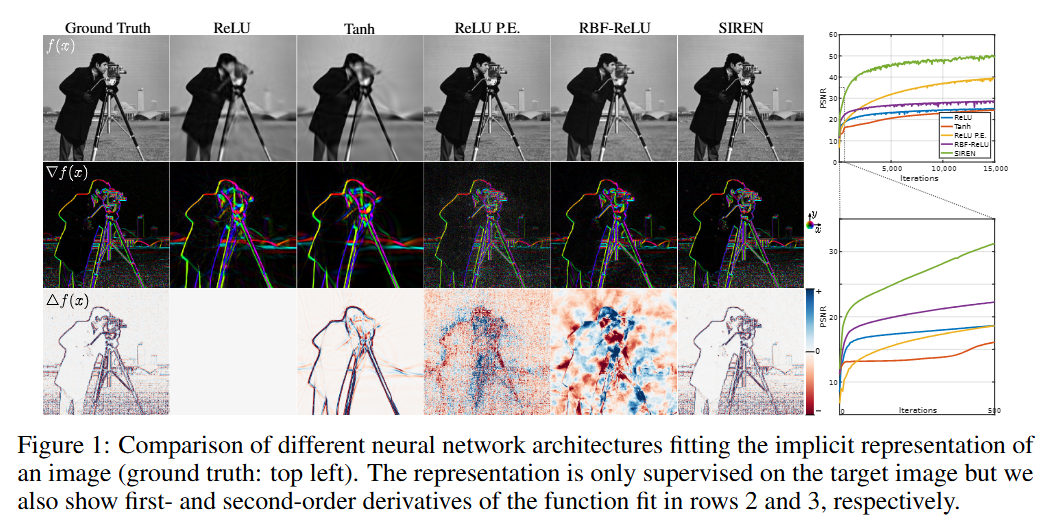

> 隐式神经表示可以直接从系统动力学的监督中求解常微分方程或偏微分方程，而神经常微分方程通过将传统常微分方程求解器（例如隐式亚当斯或龙格-库塔法）与参数化函数动力学的网络相结合，允许进行连续函数建模。所提出的架构可能与此领域的工作互补。


## a principled initialization scheme


### why we need initialization?

>- 如果权重初始化太小-->输出几乎线性化，模型学不到高频
>- 如果权重初始化太大-->梯度爆炸

### what the output distribution should look like after actviation?

- 对于$x \in U(-1,1)$, and the output $y=\sin(ax+b)$
> 当$a > \frac{\pi}{2}$时，就是让输入至少覆盖半个周期，输出的y静思服从一种U形Beta分布，两变高中间低。这意味着：正弦激活的输出在区间两端（接近 ±1）更常出现。




### 考虑一层神经元的输入分布

一个神经元的输入是前一层的输出线性组合：

$y = \sin(w^T x + b)$

其中 $x \in \mathbb{R}^n)，(w \in \mathbb{R}^n$。

假设：

$$w_i \sim U(-c/\sqrt{n}, c/\sqrt{n})$$

也就是每个权重在这个范围内均匀分布。

作者推导（细节在附录）：

* 当 n 很大时，点积 $w^T x$ 近似服从正态分布
  
  $$w^T x \sim \mathcal{N}(0, c^2 / 6)$$
  
* 把这个结果再输入到正弦函数中，输出就变成 arcsin 分布；
* 只要 $c > \sqrt{6}$，输出就能覆盖足够多的频率成分。

---

### 权重大小与频率的关系

SIREN 中的权重 (w) 可以被理解为**正弦函数的角频率**（angular frequency），
偏置 (b) 则是**相位偏移**。

也就是说：

* 较大的 |w| → 代表更高的频率；
* 较小的 |w| → 代表低频。

作者观察到：

* 当 $|w^T x| < \pi/4$ 时，$\sin(w^T x) $ 近似线性；
* 当幅度大于这个范围后，频率信息才开始显现。

他们实验证明：

> 初始层保持空间频率基本恒定（低频），
> 之后层会逐步增加频率，从而提升表达复杂度。

---

### 最终的初始化方案

根据上面的分析，他们提出以下初始化规则：

### 对隐藏层

$$
w_i \sim U(-\sqrt{6}/n, \sqrt{6}/n)$$

这能让每个神经元的输入分布标准差约为 1，
避免梯度过小或过大，保持激活稳定。

### 对第一层（最关键）

第一层的作用是把输入坐标映射成正弦波信号。
他们用一个额外的频率因子 $\omega_0$  $来控制尺度：

$$y = \sin(\omega_0 W x + b)$$


并选择：$\omega_0 = 30$,这样在输入区间 ([-1,1]) 上大约覆盖 30 个周期。
这能保证模型在初始阶段就能捕捉高频结构。


### 训练表现

他们发现：

* 按这种初始化，SIREN 网络在所有任务上**收敛更快、稳定性更好**；
* 如果随便初始化（例如 Xavier、He 初始化），
  模型会出现训练不收敛或表现差的问题；
* 在优化上，他们用的是 **Adam**，对这种初始化效果非常好。


### 总结一句话

> **这一节的核心思想：**
>
> * 正弦网络的权重控制着频率；
> * 不恰当的初始化会导致网络输出发散或退化为线性；
> * 作者推导出一种数学上合理的初始化规则（权重范围与 √6 有关）；
> * 并通过设置第一层的频率因子 $\omega_0 = 30$ ，让网络能有效表示高频信号。

## Solving the Helmholtz and Wave Equations

### Solving for the wavefield

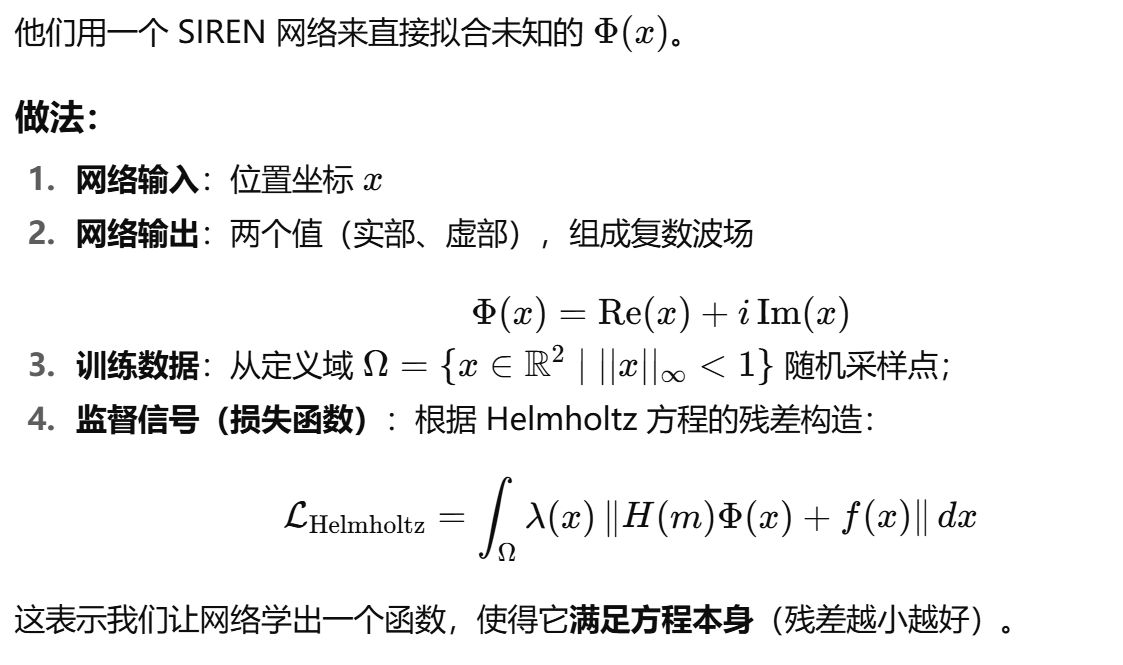

传统方法（数值解 PDE，比如有限差分或有限元）：

需要网格离散；

对高频波动的方程（如 Helmholtz 方程）计算昂贵、不稳定。

SIREN 的优势：

直接表示连续函数 不用网格；

可以自然捕捉高频波动（因为正弦激活函数）；

学到的函数在空间中是连续、可导的。


### 实验

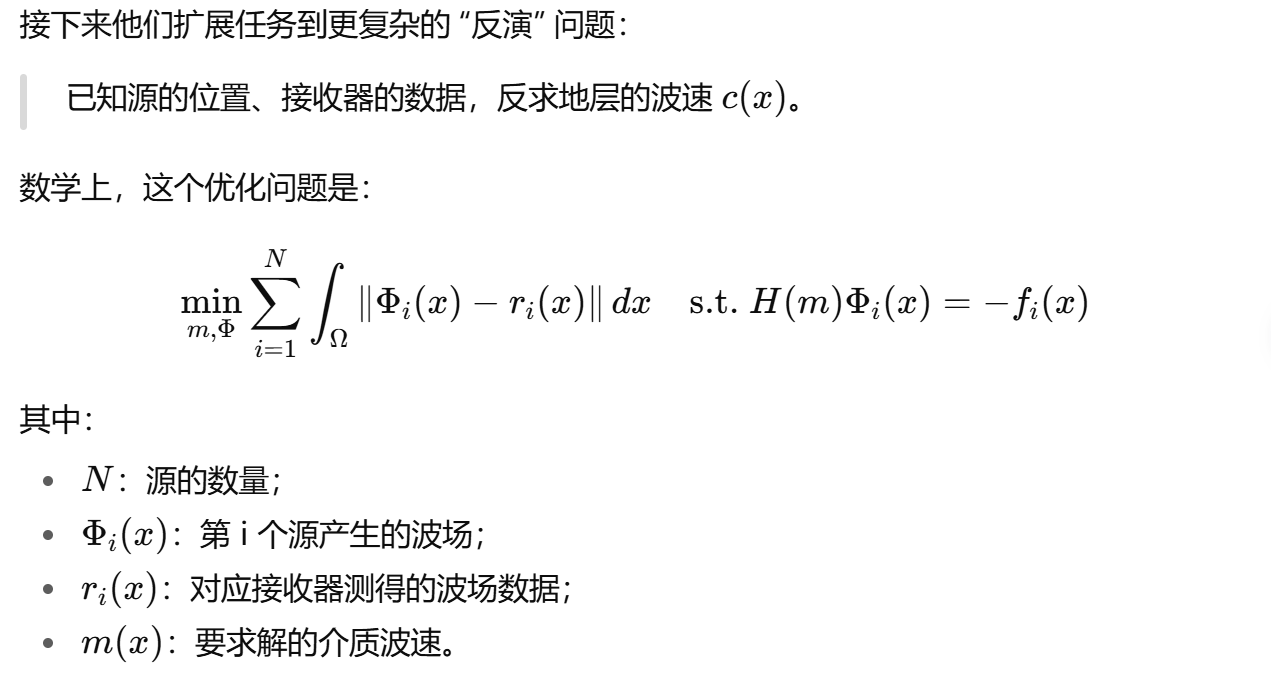

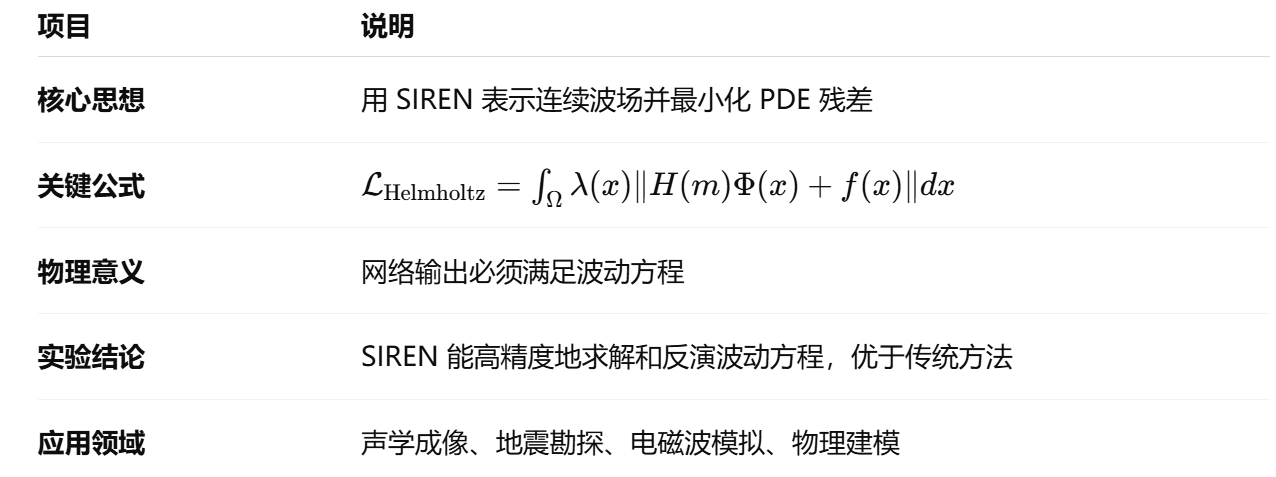

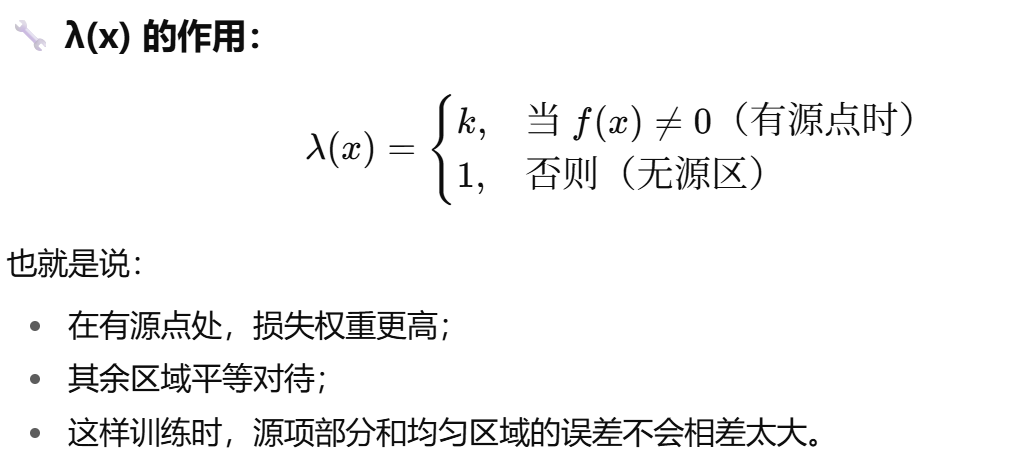


### 实验结果

| 方法        | 波场精度    | 波速反演   | 伪影     |
| --------- | ------- | ------ | ------ |
| 传统 FWI    | 易陷入局部最优 | 收敛慢    | 存在阶梯伪影 |
| **SIREN** | 精度高、收敛快 | 波速估计准确 | 几乎无伪影  |

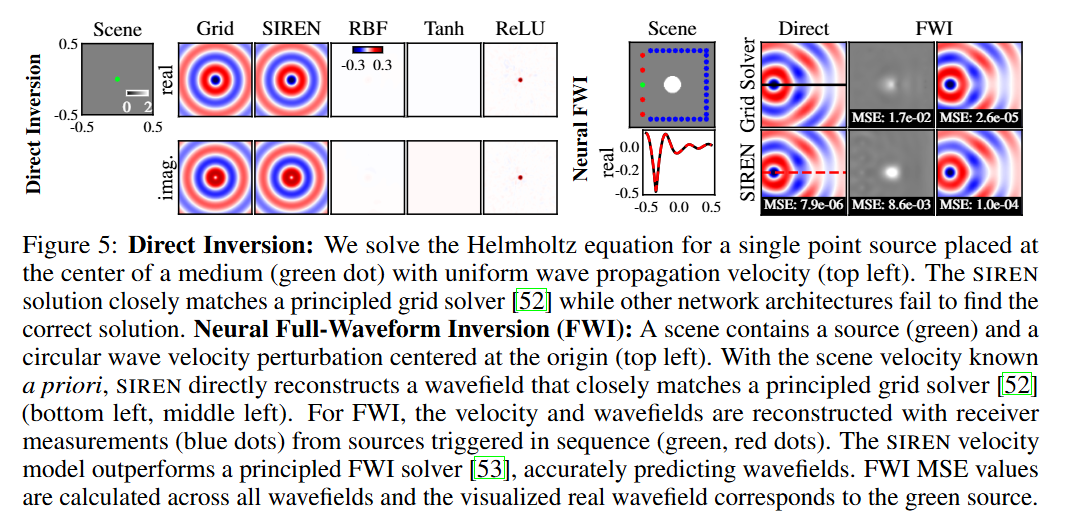

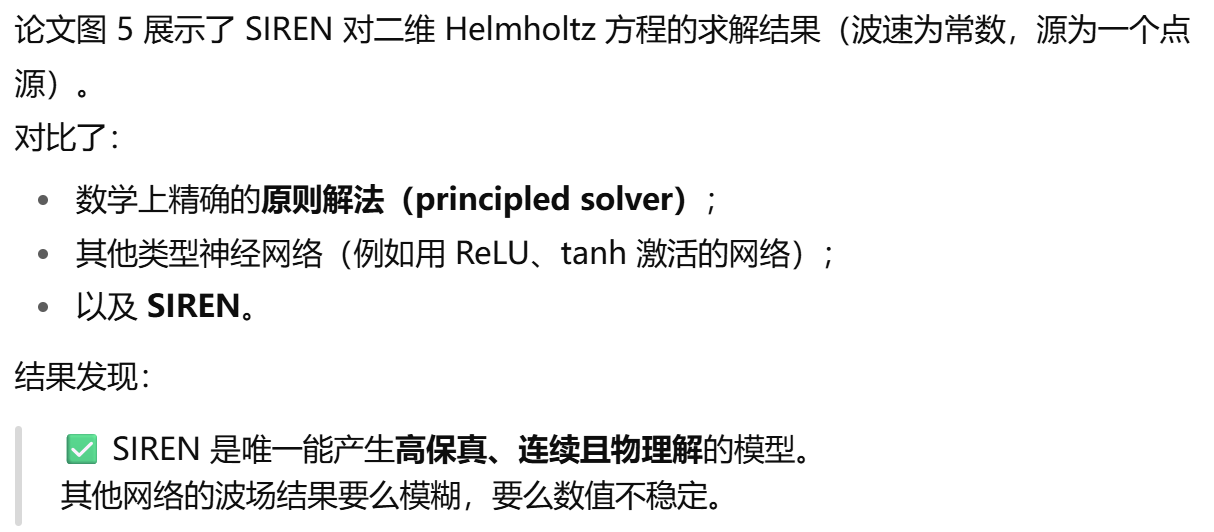

## future work

- 作者提到Formalizing the distribution of output frequencies throughout SIRENs proves to be a hard task and is out of the scope of this work.